그로버 알고리즘

여러 데이터에서 특정한 항목을 찾을 때 사용하는 알고리즘


원리

예를 들어 큐빗이 두개일 때 중첩상태 00,01,10,11의 확률이 1/4로 존재한다
우리가 찾고자 하는 항목을 phase inversion을 해준다
00+01+10+11  -> 00-01+10+11

네개의 양자 상태가 관측 될 수 있는 확률의 평균을 구한다

평균값에 대해 다시 inversion을 취하면 01에 대한 확률만 높아진다

반복하여 1에 가까운 확률을 만든다

1단계
state preparation : 답이 될 수 있는 모든 case들을 생성
2단계
oracle : 정답이나 찾고있는 값을 설정
3단계
diffusion operator : 확률을 확대해서 알고리즘 종료시 답으로 측정되도록 하는 것


원하는 대상의 위치는 어떻게 찾을까?
중텁


In [3]:
#연습 

#초기화
import matplotlib.pyplot as plt
import numpy as np
import math

#qiskit
from qiskit import IBMQ,Aer,transpile,execute
from qiskit import QuantumCircuit,ClassicalRegister,QuantumRegister
from qiskit.providers.ibmq import least_busy

from qiskit.visualization import plot_histogram

In [2]:
n = 2
grover_circuit = QuantumCircuit(n)

def initialize_s(qc,qubits):
    for q in qubits:
        qc.h(q)
    return qc

/opt/conda/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


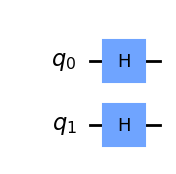

In [3]:
grover_circuit = initialize_s(grover_circuit,[0,1])
grover_circuit.draw()

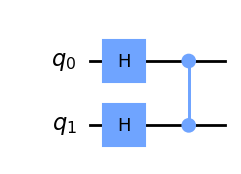

In [4]:
# 11 성분에 oracle 적용
grover_circuit.cz(0,1)
grover_circuit.draw()

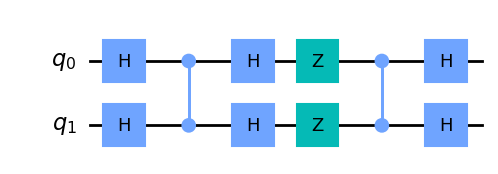

In [5]:
#diffusion operator(U_s)
grover_circuit.h([0,1])
grover_circuit.z([0,1])
grover_circuit.cz(0,1)
grover_circuit.h([0,1])
grover_circuit.draw()

In [6]:
#알고리즘 시험
sv_sim = Aer.get_backend('statevector_simulator')
result = sv_sim.run(grover_circuit).result()
statevec = result.get_statevector()

from qiskit.visualization import array_to_latex
array_to_latex(statevec,prefix="|\\psi\\rangle =")

<IPython.core.display.Latex object>

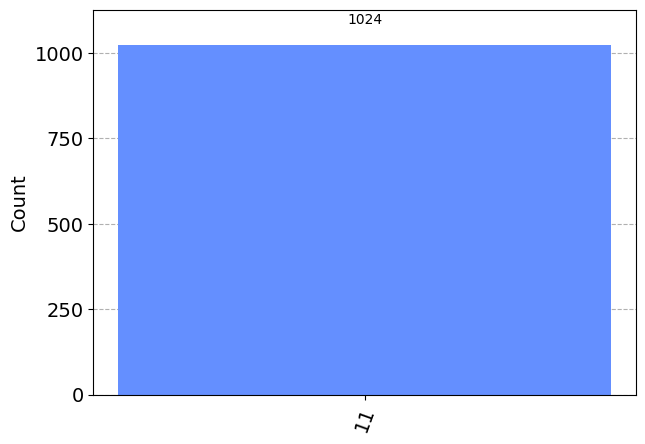

In [7]:
grover_circuit.measure_all()

qasm_sim = Aer.get_backend('qasm_simulator')
result = qasm_sim.run(grover_circuit).result()
counts = result.get_counts()
plot_histogram(counts)

In [8]:
#실제 머신으로 진행

provider = IBMQ.load_account()
provider = IBMQ.get_provider("ibm-q")
device = least_busy(provider.backends(filters = lambda x: x.configuration().n_qubits >= 3 and not x.configuration().simulator and x.status().operational == True))
print(device)

/tmp/ipykernel_82/1618837369.py:3: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  provider = IBMQ.load_account()


ibm_osaka


In [9]:
from qiskit.tools.monitor import job_monitor

transpiled_grover_circuit = transpile(grover_circuit, device, optimization_level=3)
job = device.run(transpiled_grover_circuit)
job_monitor(job,interval=2)

Job Status: job has successfully run


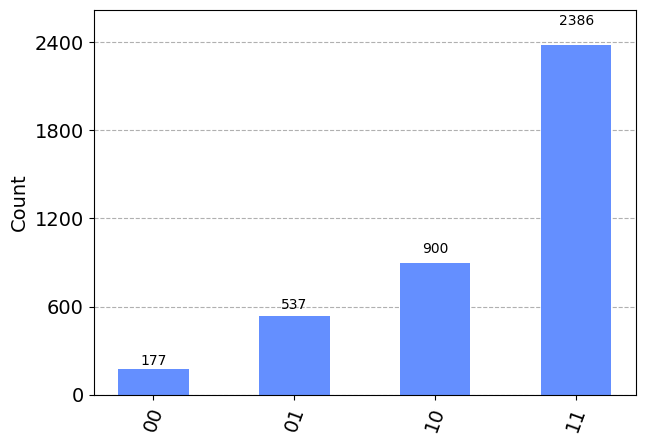

In [11]:
result = job.result()
answer = result.get_counts(grover_circuit)
plot_histogram(answer)

In [21]:
# 3qubit 연습
# |101> 과 |110> 찾기

qc = QuantumCircuit(3)
qc.cz(0, 2)
qc.cz(1, 2)
oracle_ex3 = qc.to_gate()
oracle_ex3.name = "U$_\omega$"

In [31]:
#diffuser 정의

def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    for qubit in range(nqubits):
        qc.h(qubit)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    for qubit in range(nqubits):
        qc.x(qubit)
    for qubit in range(nqubits):
        qc.h(qubit)
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

/tmp/ipykernel_82/2913899037.py:11: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.mct()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.mcx as direct replacement.
  qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli


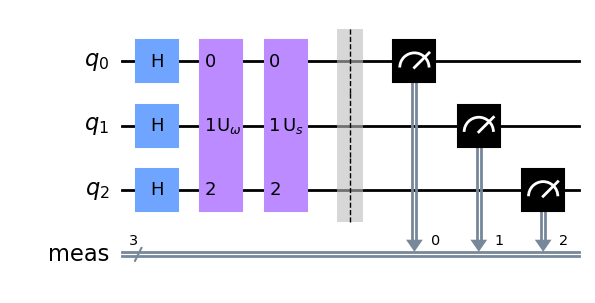

In [23]:
#회로 설계
n = 3
grover_circuit = QuantumCircuit(n)
grover_circuit = initialize_s(grover_circuit, [0,1,2])
grover_circuit.append(oracle_ex3, [0,1,2])
grover_circuit.append(diffuser(n), [0,1,2])
grover_circuit.measure_all()
grover_circuit.draw()

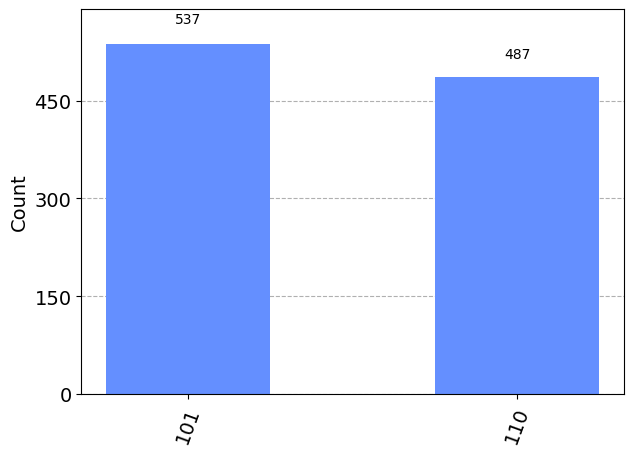

In [24]:
#실험

qasm_sim = Aer.get_backend('qasm_simulator')
transpiled_grover_circuit = transpile(grover_circuit, qasm_sim)
results = qasm_sim.run(transpiled_grover_circuit).result()
counts = results.get_counts()
plot_histogram(counts)

In [25]:
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 3 and 
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

least busy backend:  ibm_osaka


In [28]:
transpiled_grover_circuit = transpile(grover_circuit, device, optimization_level=3)
job = device.run(transpiled_grover_circuit)
job_monitor(job, interval=2)

Job Status: job has successfully run


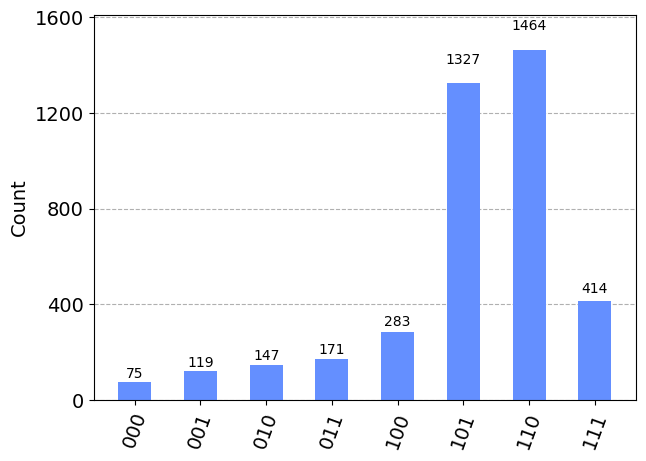

In [29]:
results = job.result()
answer = results.get_counts(grover_circuit)
plot_histogram(answer)

문제에 적용하기

In [32]:
pip install git+https://github.com/qiskit-community/qiskit-textbook.git#subdirectory=qiskit-textbook-src

  Cloning https://github.com/qiskit-community/qiskit-textbook.git to /tmp/pip-req-build-ajq7lqgr
  Running command git clone --filter=blob:none --quiet https://github.com/qiskit-community/qiskit-textbook.git /tmp/pip-req-build-ajq7lqgr
  Resolved https://github.com/qiskit-community/qiskit-textbook.git to commit 0ae905083ec3872d7ddc6bb4001d5468f476d93f
  Preparing metadata (setup.py) ... done
  Created wheel for qiskit-textbook: filename=qiskit_textbook-0.1.0-py3-none-any.whl size=17522 sha256=88ff8ec7000ae0c11d457add5980bda1e4d07acadd604ef08bccc624ca4d8d39
  Stored in directory: /tmp/pip-ephem-wheel-cache-ktt9kj8e/wheels/a4/af/1e/358474758f89b7223d73e3a3b05d32a15554fede054868448c
Successfully built qiskit-textbook
Note: you may need to restart the kernel to use updated packages.


Solutions:
|0111>
|1001>


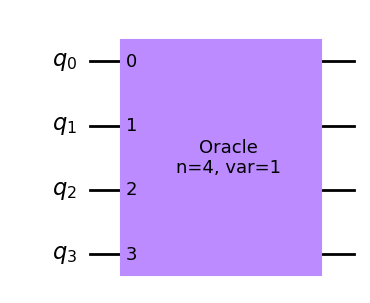

In [16]:
from qiskit_textbook.problems import grover_problem_oracle

n = 4
oracle = grover_problem_oracle(n,variant=1,print_solutions = True)
qc = QuantumCircuit(n)
qc.append(oracle,[0,1,2,3])
qc.draw()

1.grover_problem_oracle(4, variant=2) uses 4 qubits and has 1 solution.
    a. How many iterations do we need to have a > 90% chance of measuring this solution?
    ⌊pi/4 * sqrt(N/m) ⌋ = 3??
    b. Use Grover's algorithm to find this solution state. 
    c. What happens if we apply more iterations than the number we calculated in problem 1a above? Why?

2.With 2 solutions and 4 qubits, how many iterations do we need for a >90% chance of measuring a solution? Test your answer using the oracle grover_problem_oracle(4, variant=1) (which has two solutions).

3.Create a function, grover_solver(oracle, iterations) that takes as input:

A Grover oracle as a gate (oracle)
An integer number of iterations (iterations)
and returns a QuantumCircuit that performs Grover's algorithm on the 'oracle' gate, with 'iterations' iterations.

그로버 알고리즘으로 스도쿠 풀기

문제를 회로로 전환

v0 ≠ v1   # check along top row

v2 ≠ v3   # check along bottom row

v0 ≠ v2   # check down left column

v1 ≠ v3   # check down right column

In [17]:
#위의 조건 : 네가지의 value가 모두 다른것을 나타냄

clause_list = [[0,1],[0,2],[1,3],[2,3]]

In [18]:
def XOR(qc,a,b,output):
    qc.cx(a,output)
    qc.cx(b,output)

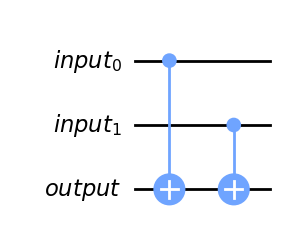

In [19]:
in_qubits = QuantumRegister(2,name = 'input')
out_qubit = QuantumRegister(1,name = 'output')
qc = QuantumCircuit(in_qubits,out_qubit)
XOR(qc,in_qubits[0],in_qubits[1],out_qubit)
qc.draw()

/tmp/ipykernel_156/2094860745.py:14: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.mct()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.mcx as direct replacement.
  qc.mct(clause_qubits, output_qubit)


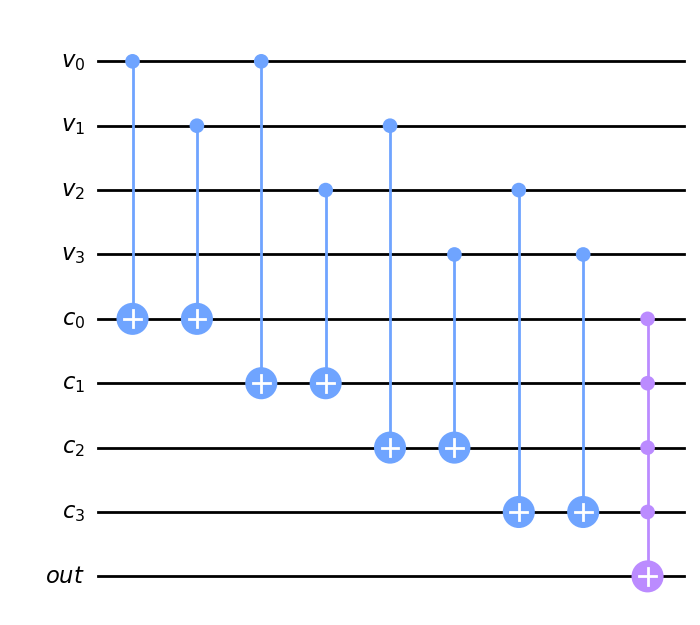

In [24]:
#위의 방식을 이용해서 네가지 조건을 적용시킴

clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit)

# Compute clauses
i = 0
for clause in clause_list:
    XOR(qc, clause[0], clause[1], clause_qubits[i])
    i += 1

# Flip 'output' bit if all clauses are satisfied
qc.mct(clause_qubits, output_qubit)

qc.draw()

phase kickback을 통해 grover oracle로 전환해야함
3개의 레지스터가 필요함
1. 스도쿠 변수를 저장할 레지스터
2. .clause를 저장할 레지스터
3. 결과를 저장할 qubit


/tmp/ipykernel_156/330770685.py:17: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.mct()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.mcx as direct replacement.
  qc.mct(clause_qubits, output_qubit)


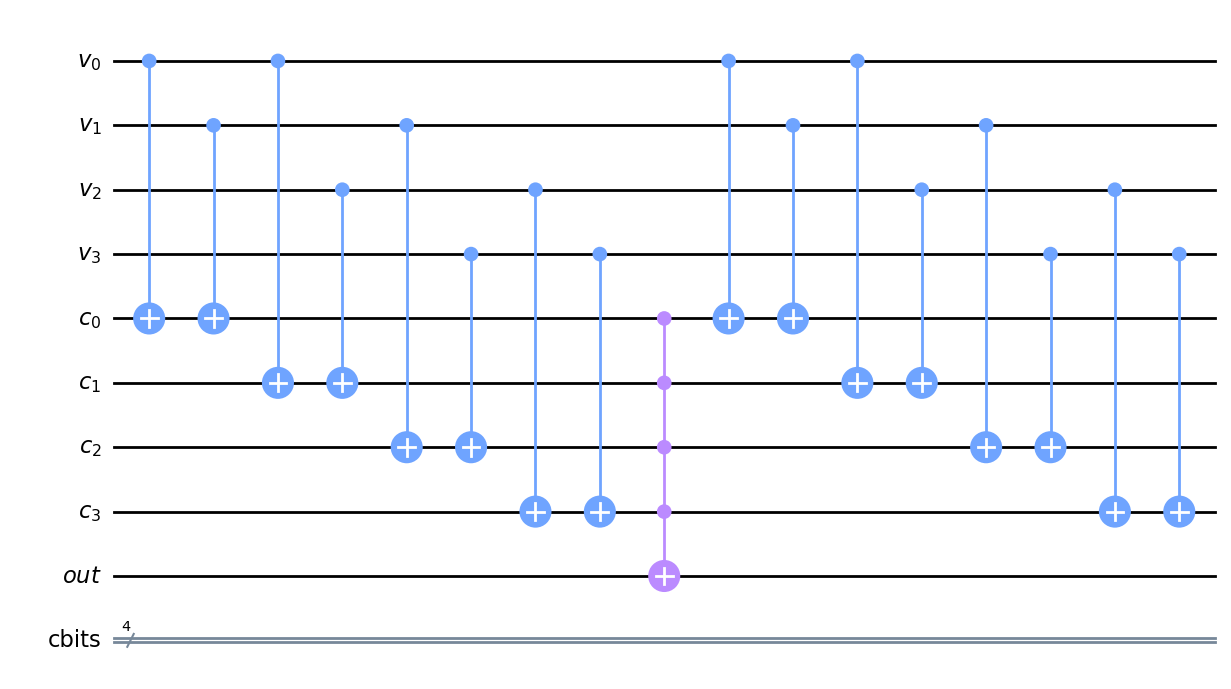

In [25]:
# uncomputation : 회로를 grover oracle로 전환시키기 전에 c 레지스터들을 모두 |0>으로 초기화 시키는 작업

var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(4, name='cbits')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

def sudoku_oracle(qc, clause_list, clause_qubits):
    # Compute clauses
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i += 1

    # Flip 'output' bit if all clauses are satisfied
    qc.mct(clause_qubits, output_qubit)

    # Uncompute clauses to reset clause-checking bits to 0
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i += 1

sudoku_oracle(qc, clause_list, clause_qubits)
qc.draw()

/tmp/ipykernel_156/330770685.py:17: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.mct()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.mcx as direct replacement.
  qc.mct(clause_qubits, output_qubit)
/tmp/ipykernel_156/2913899037.py:11: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.mct()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.mcx as direct replacement.
  qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli


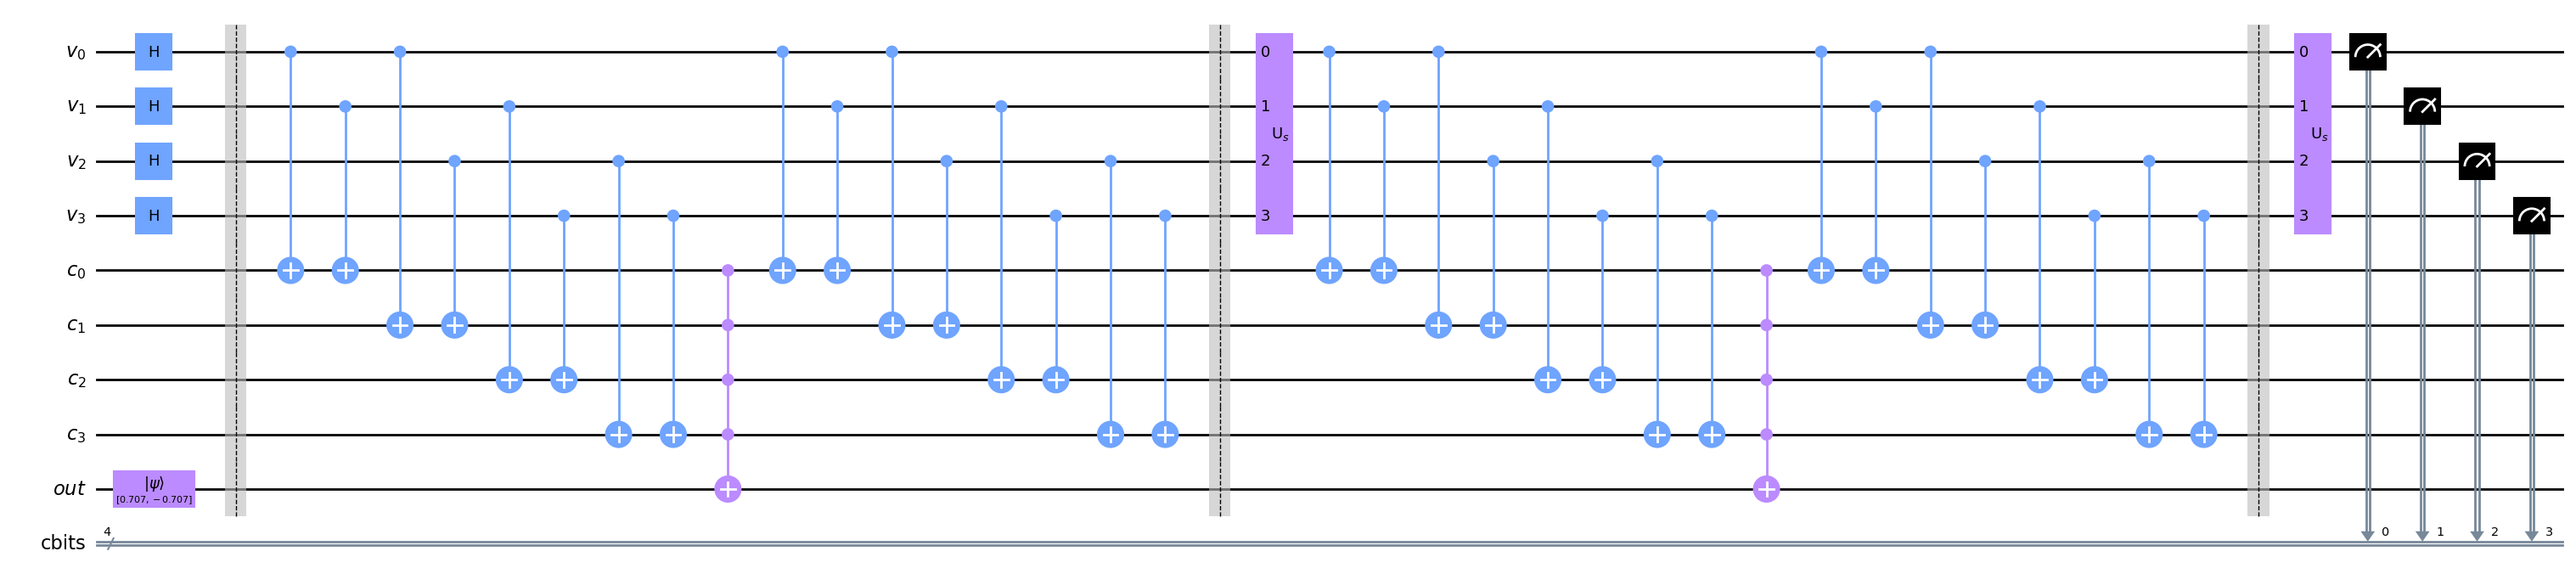

In [34]:
#결과

var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(4, name='cbits')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

# Initialize 'out0' in state |->
qc.initialize([1, -1]/np.sqrt(2), output_qubit)

# Initialize qubits in state |s>
qc.h(var_qubits)
qc.barrier() 

## First Iteration
sudoku_oracle(qc, clause_list, clause_qubits)
qc.barrier()  
qc.append(diffuser(4), [0,1,2,3])

## Second Iteration
sudoku_oracle(qc, clause_list, clause_qubits)
qc.barrier()  
qc.append(diffuser(4), [0,1,2,3])

qc.measure(var_qubits, cbits)

qc.draw(fold=-1)

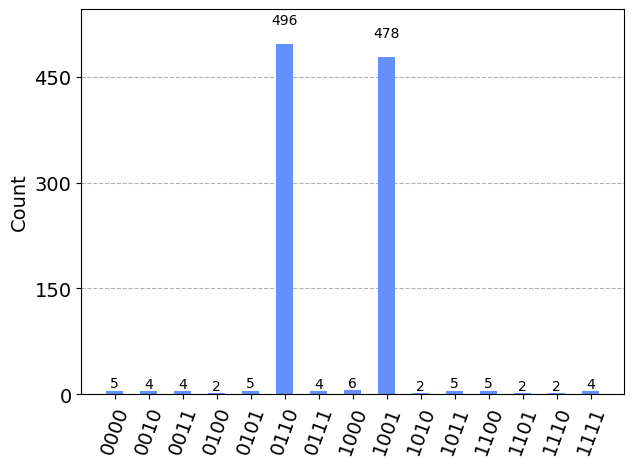

In [36]:
qasm_simulator = Aer.get_backend('qasm_simulator')
transpiled_qc = transpile(qc, qasm_simulator)
result = qasm_simulator.run(transpiled_qc).result()
plot_histogram(result.get_counts())